<a href="https://colab.research.google.com/github/lkhart/kaggle_house_prices/blob/main/regression_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Price Regression Modeling**

#### [Kaggle Competition Entry](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description)/Class Assignment 
#### Laura Hart - MSDS 422 - Winter 2022

The objective of this exercise is to predict sale price of homes in Ames, Iowa given the available training data. In previous sections, we conducted an exploratory analysis of the provided data and created features to prepare the data for modeling, and we tested performance of linear regression models on this data. Now, we will look at three additional regularized regression modeling techniques:


*   Lasso 
*   Ridge
*   ElasticNet



## Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import metrics
from google.colab import files

In [2]:
# remove cloned repo if exists
# !rm -r kaggle_house_prices

In [3]:
# clone git repo
!git clone 'https://github.com/lkhart/kaggle_house_prices.git'

fatal: destination path 'kaggle_house_prices' already exists and is not an empty directory.


In [4]:
# run data prep notebook
%run kaggle_house_prices/data_prep.ipynb

(1460, 81)
(1459, 80)


In [5]:
train_df_prepped.head()

,Id,MSZoning,Neighborhood,OverallQual,MasVnrType,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,GrLivArea,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,YearBuiltBin,TotRmsBin,HasPool,NumFam,RelativeCond,LastRemod,TotalFullBath,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,HasScreenPorch,PartialSale
0,1,RL,CollgCr,7,BrkFace,Gd,PConc,Gd,856,Ex,Y,856,1710,Gd,None,Attchd,RFn,2,548,208500,2000-2005,6-8,0,Single,Above Average,Since1980,3,0,1,0,0,0
1,2,RL,Veenker,6,None,TA,CBlock,Gd,1262,Ex,Y,1262,1262,TA,TA,Attchd,RFn,2,460,181500,1960-79,6-8,0,Single,Above Average,Pre1980,2,1,0,0,0,0
2,3,RL,CollgCr,7,BrkFace,Gd,PConc,Gd,920,Ex,Y,920,1786,Gd,TA,Attchd,RFn,2,608,223500,2000-2005,6-8,0,Single,Above Average,Since1980,3,0,1,0,0,0
3,4,RL,Crawfor,7,None,TA,BrkTil,TA,756,Gd,Y,961,1717,Gd,Gd,Detchd,Unf,3,642,140000,pre-1960,6-8,0,Single,Above Average,Pre1980,2,0,1,1,0,0
4,5,RL,NoRidge,8,BrkFace,Gd,PConc,Gd,1145,Ex,Y,1145,2198,Gd,TA,Attchd,RFn,3,836,250000,2000-2005,9 or more,0,Single,Above Average,Since1980,3,1,1,0,0,0


In [6]:
test_df_prepped.head()

,Id,TotalBsmtSF,1stFlrSF,GarageArea,GrLivArea,MSZoning,Neighborhood,OverallQual,MasVnrType,ExterQual,Foundation,BsmtQual,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageCars,HasPool,YearBuiltBin,NumFam,RelativeCond,LastRemod,TotalFullBath,TotRmsBin,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,HasScreenPorch,PartialSale
0,1461,882.0,896,730.0,896,RH,NAmes,5,None,TA,CBlock,TA,TA,Y,TA,None,Attchd,Unf,1.0,0,1960-79,Single,Above Average,Pre1980,1.0,5 or fewer,1,0,0,1,0
1,1462,1329.0,1329,312.0,1329,RL,NAmes,6,BrkFace,TA,CBlock,TA,TA,Y,Gd,None,Attchd,Unf,1.0,0,pre-1960,Single,Above Average,Pre1980,1.0,6-8,1,1,0,0,0
2,1463,928.0,928,482.0,1629,RL,Gilbert,5,None,TA,PConc,Gd,Gd,Y,TA,TA,Attchd,Fin,2.0,0,1980-1999,Single,Above Average,Since1980,2.0,6-8,1,1,0,0,0
3,1464,926.0,926,470.0,1604,RL,Gilbert,6,BrkFace,TA,PConc,TA,Ex,Y,Gd,Gd,Attchd,Fin,2.0,0,1980-1999,Single,Above Average,Since1980,2.0,6-8,1,1,0,0,0
4,1465,1280.0,1280,506.0,1280,RL,StoneBr,8,None,Gd,PConc,Gd,Ex,Y,Gd,None,Attchd,RFn,2.0,0,1980-1999,Single,Above Average,Since1980,2.0,5 or fewer,0,1,0,1,0


## Modeling Prep

In [7]:
# features to be included
features = ['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'GrLivArea', 'TotalFullBath', 'MSZoning', 'Neighborhood', 'OverallQual', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'YearBuiltBin', 'NumFam', 'RelativeCond', 'TotalFullBath', 'TotRmsBin', 'HasPool', 'LastRemod', 'HasWoodDeck', 'HasOpenPorch', 'HasEnclosedPorch', 'HasScreenPorch', 'PartialSale']

In [8]:
# define categorical variables to be included
cat_vars = ['MSZoning', 'Neighborhood', 'OverallQual', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish',  'YearBuiltBin', 'NumFam', 'RelativeCond', 'TotRmsBin', 'HasPool', 'LastRemod', 'HasWoodDeck', 'HasOpenPorch', 'HasEnclosedPorch', 'HasScreenPorch', 'PartialSale']

num_vars = ['TotalBsmtSF', '1stFlrSF', 'GarageArea', 'GrLivArea', 'GarageCars', 'TotalFullBath']

In [9]:
# encoding cat vars as dummy variables

# train
train_df_encoded = pd.get_dummies(data=train_df_prepped[features], columns=cat_vars, drop_first=True)

#test
final_test_df = pd.get_dummies(data=test_df_prepped[features[1:]], columns=cat_vars, drop_first=True)

In [10]:
# train test split
X = train_df_encoded.drop(['SalePrice'], axis=1)
y = np.log(train_df_encoded['SalePrice'])

print(X.shape)
print(y.shape)

# set seed for reproducibility
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(X_train.shape)
print(y_train.shape)

(1460, 96)
(1460,)
(1168, 96)
(1168,)


In [11]:
sscaler = StandardScaler()

# standard scaling on independent variables
X_train[num_vars] = sscaler.fit_transform(X_train[num_vars])
X_test[num_vars] = sscaler.transform(X_test[num_vars])

# standard scaling for final test df
final_test_df[num_vars] = sscaler.transform(final_test_df[num_vars])

# Lasso

The Lasso regularization approach eliminates variables that are not found to be relevant in predicting the dependent variable (those with zero coefficient value) in order to reduce the number of features, thereby reducing variance. The final lasso model I created here performed better in the Kaggle competition than any of the linear regression models I submitted last week, and was the second best performer of all models I have submitted (most successful was ridge regression).

#### Lasso Train

In [12]:
# hyperparameter options for alpha
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]}

lasso = Lasso(tol=1e-2, max_iter=100000)

# cross validation
folds = 10
lasso_cv = GridSearchCV(estimator = lasso,
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score = True,
                        verbose = 1)

lasso_cv.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=Lasso(max_iter=100000, tol=0.01),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [13]:
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'alpha': 0.0001}
-0.09870670180929497


In [14]:
# select lasso model with best performing param alpha
alpha = 0.0001

lasso = Lasso(alpha=alpha, tol=1e-2, max_iter=100000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, max_iter=100000, tol=0.01)

In [15]:
# predict R-squared value of this model on train data
y_train_pred = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.8947222644745604


In [16]:
# predict R-squared value of this model on test data
y_test_pred = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8619971425035967


In [17]:
print('RMSE: ', metrics.mean_squared_error(y_test, y_test_pred))

RMSE:  0.023758776169460004


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

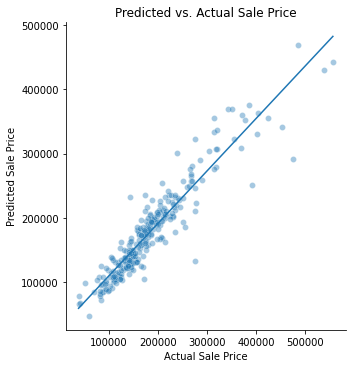

In [18]:
# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(np.exp(y_test), np.exp(y_test_pred), 1)

# visualize predictions vs. actual SalePrice values from Lasso model
sns.relplot(x=np.exp(y_test), y=np.exp(y_test_pred), kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(np.exp(y_test)), y=np.unique(np.poly1d(b+m*np.unique(np.exp(y_test)))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

#### Lasso Test (apply fitted model to test set)

In [19]:
# apply lasso model to final test df
final_pred_lasso = lasso.predict(final_test_df)

# get exponential of predictions (as they were in log form)
final_pred_lasso = np.exp(final_pred_lasso)

In [20]:
final_pred_lasso

array([125733.77719191, 137723.81360384, 178878.16775039, ...,
       163510.19093393, 116213.13757134, 219190.490742  ])

In [21]:
lassosaleprice = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_pred_lasso})

In [22]:
# export final predictions for submission
lassosaleprice.to_csv('lasso_predictions.csv', index=False)

# files.download('lasso_predictions.csv')

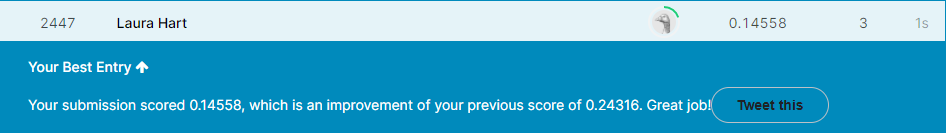

# Ridge
Like the lasso modeling technique, the ridge technique is also designed to reduce variance in a model with many independent variables. Ridge regression is specifically designed to reduce variance in a model trained on data with high multicollinearity by reducing the coefficient values of features that are overinflated by multicollinearity. Among the models I created, this ridge regression was most successful in the Kaggle competition.

#### Ridge Train

In [23]:
# hyperparameter options for alpha
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 1, 1.2, 1.5, 2, 3, 5, 10, 20]}

ridge = Ridge(tol=1e-2, max_iter=100000)

# cross validation
folds = 10
ridge_cv = GridSearchCV(estimator = ridge,
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score = True,
                        verbose = 1)

ridge_cv.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10, estimator=Ridge(max_iter=100000, tol=0.01),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 1,
                                   1.2, 1.5, 2, 3, 5, 10, 20]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [24]:
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'alpha': 1.5}
-0.09843359107444516


In [25]:
# select ridge model with best performing param alpha
alpha = 1.5

ridge = Ridge(alpha=alpha, tol=1e-2, max_iter=100000)

ridge.fit(X_train, y_train)

Ridge(alpha=1.5, max_iter=100000, tol=0.01)

In [26]:
# predict R-squared value of this model on train data
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.8934879347886115


In [27]:
# predict R-squared value of this model on test data
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8653503759254123


In [28]:
print('RMSE: ', metrics.mean_squared_error(y_test, y_test_pred))

RMSE:  0.023181478541293536


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

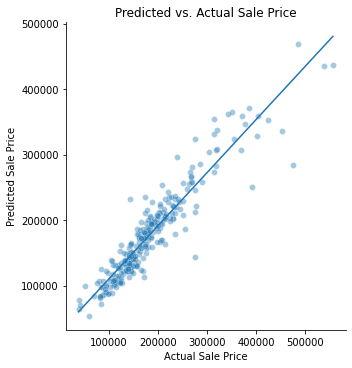

In [29]:
# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(np.exp(y_test), np.exp(y_test_pred), 1)

# visualize predictions vs. actual SalePrice values from Lasso model
sns.relplot(x=np.exp(y_test), y=np.exp(y_test_pred), kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(np.exp(y_test)), y=np.unique(np.poly1d(b+m*np.unique(np.exp(y_test)))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

#### Ridge Test (apply fitted model to test set)

In [30]:
# apply ridge model to final test df
final_pred_ridge = ridge.predict(final_test_df)

# get exponential of predictions (as they were in log form)
final_pred_ridge = np.exp(final_pred_ridge)

In [31]:
ridgesaleprice = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_pred_ridge})

In [32]:
# export final predictions for submission
ridgesaleprice.to_csv('ridge_predictions.csv', index=False)

# files.download('ridge_predictions.csv')

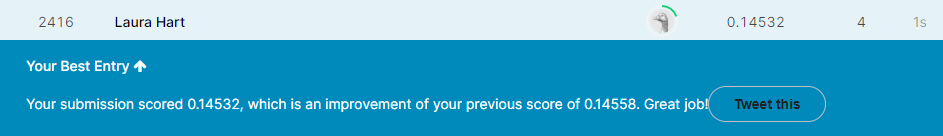

# ElasticNet

The ElasticNet regression technique combines the lasso and ridge regularization approaches, eliminating zero coefficient features (like lasso) and reducing coefficients of related features (like ridge). Of the regularized regression models I created this week, the elasticnet model was least successful in the Kaggle competition.

#### ElasticNet Train

In [33]:
# hyperparameter options
params = {'l1_ratio': [0.00001, 0.0001, 0.001, 0.05, 0.1, 0.15, 0.2, 0.85, 0.9, 0.95],
          'max_iter': [1000, 10000, 100000]} 

elasticnet = ElasticNet()

# cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

elasticnet_cv = GridSearchCV(estimator = elasticnet,
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error',
                        cv = cv,
                        return_train_score = True,
                        verbose = 1)

elasticnet_cv.fit(X_train, y_train)

Fitting 30 folds for each of 30 candidates, totalling 900 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=ElasticNet(),
             param_grid={'l1_ratio': [1e-05, 0.0001, 0.001, 0.05, 0.1, 0.15,
                                      0.2, 0.85, 0.9, 0.95],
                         'max_iter': [1000, 10000, 100000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [34]:
print(elasticnet_cv.best_params_)
print(elasticnet_cv.best_score_)

{'l1_ratio': 1e-05, 'max_iter': 1000}
-0.12959785963115497


In [35]:
# select ridge model with best performing parameters

elasticnet = ElasticNet(l1_ratio=0.00001, tol=1e-2, max_iter=1000)

elasticnet.fit(X_train, y_train)

ElasticNet(l1_ratio=1e-05, tol=0.01)

In [36]:
# predict R-squared value of this model on train data
y_train_pred = elasticnet.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.7733266272782893


In [37]:
# predict R-squared value of this model on test data
y_test_pred = elasticnet.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.760074996431818


In [38]:
print('RMSE: ', metrics.mean_squared_error(y_test, y_test_pred))

RMSE:  0.04130584366618565


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

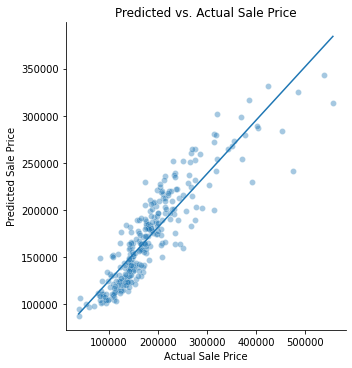

In [39]:
# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(np.exp(y_test), np.exp(y_test_pred), 1)

# visualize predictions vs. actual SalePrice values from Lasso model
sns.relplot(x=np.exp(y_test), y=np.exp(y_test_pred), kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(np.exp(y_test)), y=np.unique(np.poly1d(b+m*np.unique(np.exp(y_test)))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

#### ElasticNet Test (apply fitted model to test set)

In [40]:
# apply elasticnet model to final test df
final_pred_elasticnet = elasticnet.predict(final_test_df)

# get exponential of predictions (as they were in log form)
final_pred_elasticnet = np.exp(final_pred_elasticnet)

In [41]:
elasticnetsaleprice = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_pred_elasticnet})

In [42]:
# export final predictions for submission
elasticnetsaleprice.to_csv('elasticnet_predictions.csv', index=False)

# files.download('elasticnet_predictions.csv')

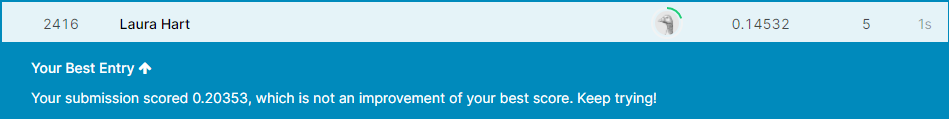